In [1]:
import shutil, os
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset

reprocess_results=True
dataset_name = "fold5"

In [3]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working')
#really low iou for nms in order to separate out lesions
cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_"+ data_set_name + "/model_final.pth",
                     "OUTPUT_DIR", "output_valid_"+ data_set_name + "/results"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

output_aug_LR/model_final.pth
output_aug_LR/results


In [ ]:
for name in [dataset_name]:
    myfunc = lambda : grab_dataset(name)
    try:
        DatasetCatalog.register(name, myfunc)
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

In [4]:
if reprocess_results:
    #build model
    from detectron2.modeling import build_model
    model = build_model(cfg)  # returns a torch.nn.Module
    from detectron2.checkpoint import DetectionCheckpointer
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
    model.eval(); #set model in evaluation mode

    from detectron2.data import build_detection_test_loader
    myloader = build_detection_test_loader(cfg,dataset_name)

    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5)
    from detectron2.evaluation import inference_on_dataset
    results_i = inference_on_dataset(model, myloader, myeval)
else:
    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
    myeval.evaluate()
    
myeval.summarize_scalars()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0

{'dataset': 'rpd_test',
 'precision': 0.7418244406196214,
 'recall': 0.5700000000000001,
 'fpr': 0.028,
 'iou': 0.2,
 'probability': 0.5}

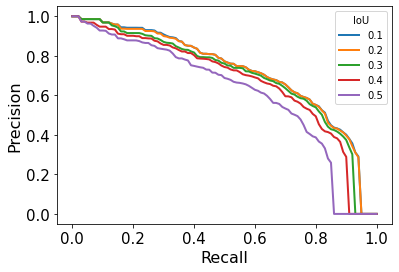

In [5]:
myeval.plot_PRcurve()

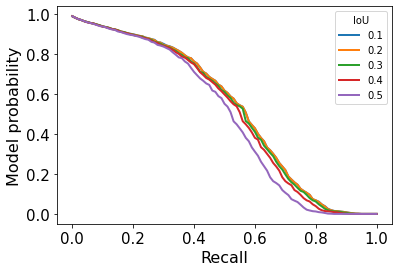

In [6]:
myeval.plot_recall_vs_prob()

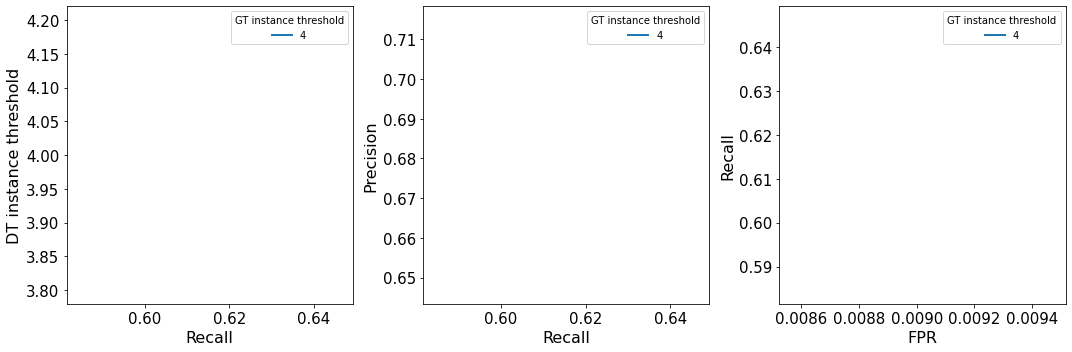

In [7]:
myeval.build_dfimg()
df = myeval.dfimg
inst = list(range(0,6))
#inst = [4]
rc = np.zeros((len(inst),))
pr = np.zeros((len(inst),))
fpr = np.zeros((len(inst),))

fig, ax = plt.subplots(1,3,figsize = [15,5])
for j,gt_thresh in enumerate(inst):
    for i,dt_thresh in enumerate(inst):
        gt = df.gt_instances>gt_thresh
        dt = df.dt_instances>dt_thresh
        rc[i] = (gt&dt).sum()/gt.sum()
        pr[i] = (gt&dt).sum()/dt.sum()
        fpr[i] = ((~gt)&(dt)).sum()/((~gt).sum())
    ax[1].plot(rc,pr,label=gt_thresh)
    ax[0].plot(rc,inst,label=gt_thresh)
    ax[2].plot(fpr,rc,label=gt_thresh)
    
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(title='GT instance threshold')

ax[0].set_xlabel('Recall')
ax[0].set_ylabel('DT instance threshold')
ax[0].legend(title='GT instance threshold')

ax[2].set_ylabel('Recall')
ax[2].set_xlabel('FPR')
ax[2].legend(title='GT instance threshold')
plt.tight_layout()

In [8]:
print(pr,rc,fpr)

[0.68085106] [0.61538462] [0.00901984]


In [9]:
df = myeval.dfimg
max_inst=np.max([df.gt_instances.max(),df.dt_instances.max()])
max_xpxs = np.max([df.gt_xpxs.max(),df.dt_xpxs.max()])
max_pxs = np.max([df.gt_pxs.max(),df.dt_pxs.max()])
print('Max instances:',max_inst)
print('Max xpxs:',max_xpxs)
print('Max pxs:',max_pxs)



Max instances: 15.0
Max xpxs: 616.0
Max pxs: 2754.0


Text(0, 0.5, 'gt_instances')

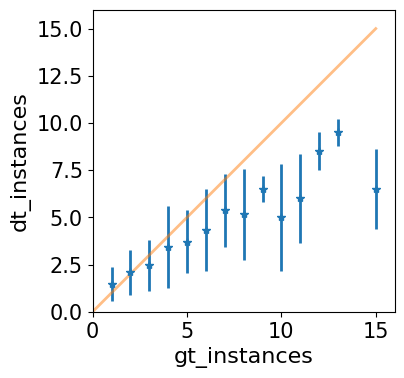

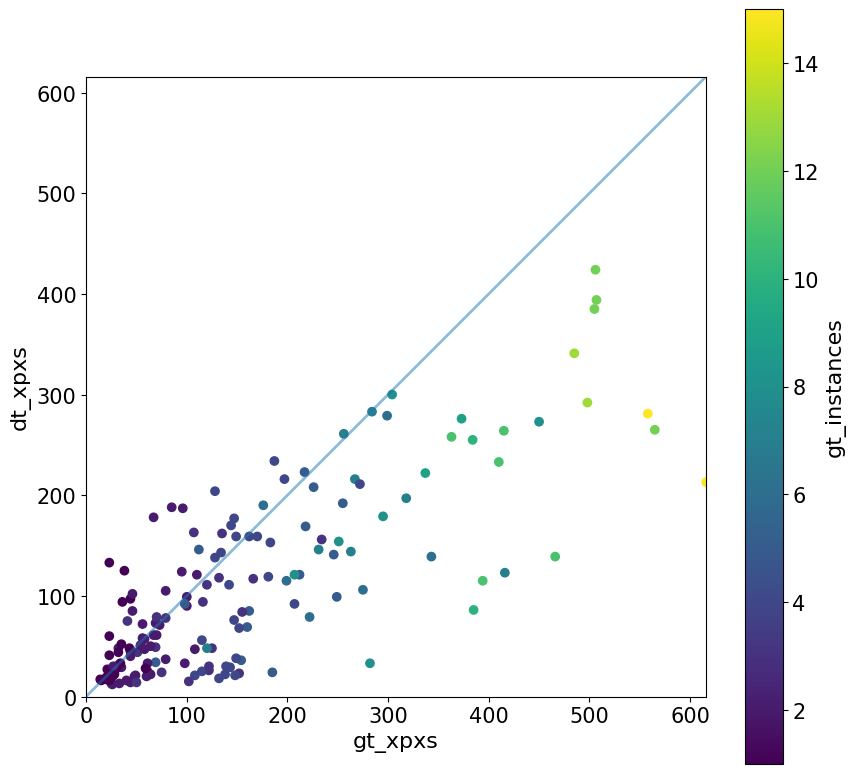

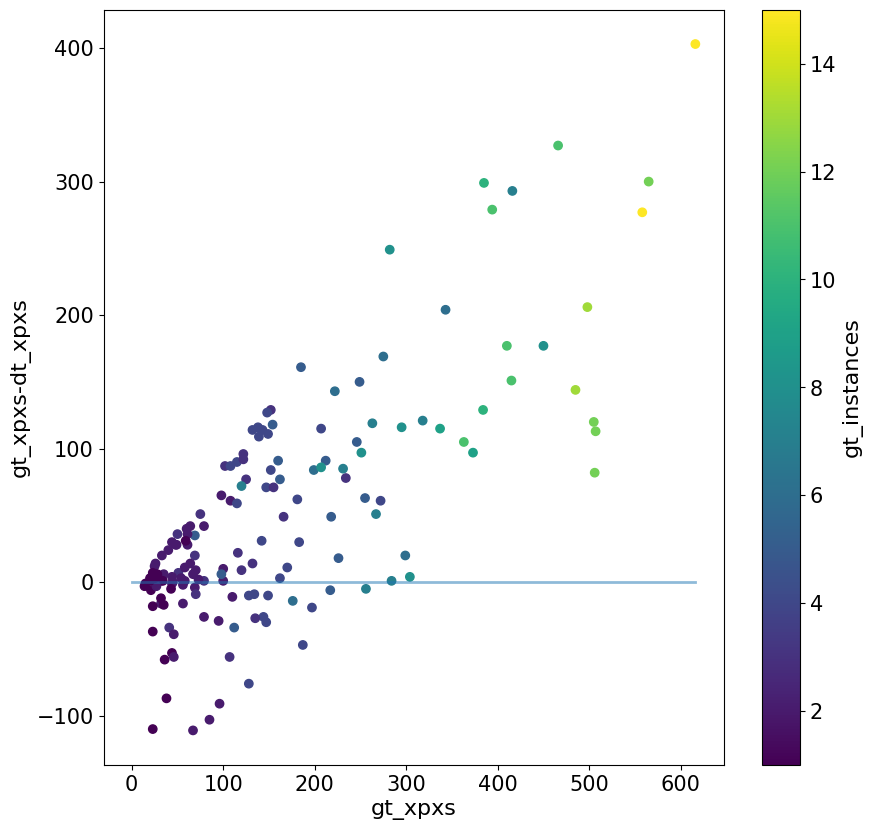

In [10]:

df = myeval.dfimg
idx = (df.gt_instances>0)&(df.dt_instances>0)
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
y = df[idx].groupby('gt_instances')['dt_instances'].mean()
yerr = df[idx].groupby('gt_instances')['dt_instances'].std()
ax.errorbar(y.index,y.values,yerr.values,fmt='*')
plt.plot([0,max_inst],[0,max_inst],alpha=.5)
plt.xlim(0,max_inst+1)
plt.ylim(0,max_inst+1)
ax.set_aspect(1)
plt.xlabel('gt_instances')
plt.ylabel('dt_instances')


dfsub = df[idx]
fig = plt.figure(figsize = [10,10],dpi=100)
ax = fig.add_subplot(111)
sc = ax.scatter(dfsub['gt_xpxs'],dfsub['dt_xpxs'],c =dfsub['gt_instances'] ,cmap='viridis')
ax.set_aspect(1)
#ax = dfsub.plot(kind = 'scatter',x=,y=,c='gt_instances')
plt.plot([0,max_xpxs],[0,max_xpxs],alpha=.5)
plt.xlim(0,max_xpxs)
plt.ylim(0,max_xpxs)
plt.xlabel('gt_xpxs')
plt.ylabel('dt_xpxs')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('gt_instances')

fig = plt.figure(figsize = [10,10],dpi=100)
ax = fig.add_subplot(111)
sc = ax.scatter(dfsub['gt_xpxs'],dfsub['gt_xpxs']-dfsub['dt_xpxs'],c =dfsub['gt_instances'] ,cmap='viridis')
#ax = dfsub.plot(kind = 'scatter',x=,y=,c='gt_instances')
plt.plot([0,max_xpxs],[0,0],alpha=.5)
plt.xlabel('gt_xpxs')
plt.ylabel('gt_xpxs-dt_xpxs')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('gt_instances')



Text(0.5, 1.0, 'FN gt instance count per B-scan')

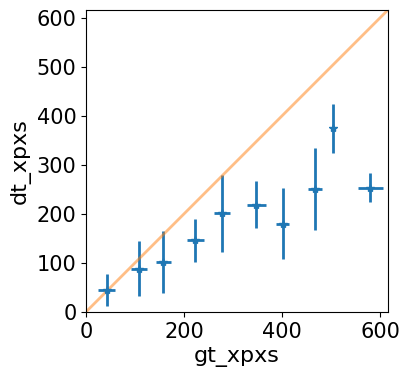

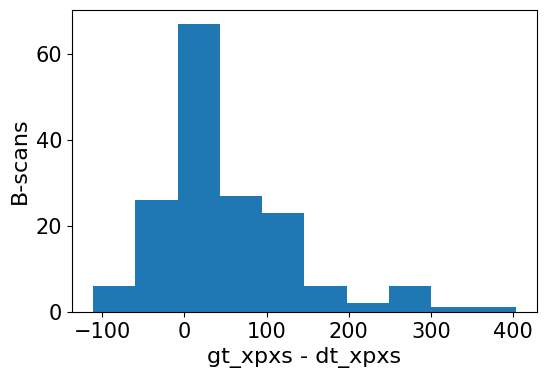

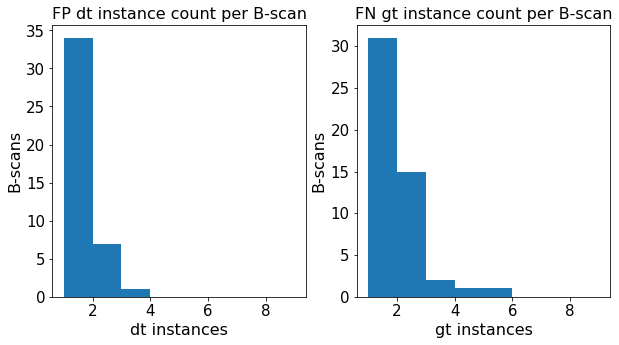

In [11]:
from scipy import stats
mu_dt,bins,bnum = stats.binned_statistic(dfsub['gt_xpxs'],dfsub['dt_xpxs'],statistic = 'mean',bins=10)
std_dt,_,_ = stats.binned_statistic(dfsub['gt_xpxs'],dfsub['dt_xpxs'],statistic = 'std',bins = bins)
mu_gt,_,_ = stats.binned_statistic(dfsub['gt_xpxs'],dfsub['gt_xpxs'],statistic='mean',bins=bins)
std_gt,_,_ = stats.binned_statistic(dfsub['gt_xpxs'],dfsub['gt_xpxs'],statistic = 'std',bins = bins)
plt.figure(dpi=100)
plt.errorbar(mu_gt,mu_dt,yerr = std_dt,xerr=std_gt,fmt='*')
plt.xlabel('gt_xpxs')
plt.ylabel('dt_xpxs')
plt.plot([0,max_xpxs],[0,max_xpxs],alpha=.5)
plt.xlim(0,max_xpxs)
plt.ylim(0,max_xpxs)
plt.gca().set_aspect(1)
#plt.title('Average detected A-scans per B-scan at each GT A-scan value')

# plt.figure()
# plt.bar(bins[:-1],height=mu_dt,width=(bins[1]-bins[0]),yerr=std_dt,align='edge')


plt.figure(dpi=100)
plt.hist(dfsub['gt_xpxs']-dfsub['dt_xpxs'])
plt.xlabel('gt_xpxs - dt_xpxs')
plt.ylabel('B-scans')
#plt.title('Distribution of A-scan error')

idx = (df.gt_instances==0)&(df.dt_instances>0)
fig,ax =plt.subplots(1,2,figsize=[10,5])
ax[0].hist(df[idx]['dt_instances'],bins = range(1,10))
ax[0].set_xlabel('dt instances')
ax[0].set_ylabel('B-scans')
ax[0].set_title('FP dt instance count per B-scan')

idx = (df.gt_instances>0)&(df.dt_instances==0)
ax[1].hist(df[idx]['gt_instances'],bins = range(1,10))
ax[1].set_xlabel('gt instances')
ax[1].set_ylabel('B-scans')
ax[1].set_title('FN gt instance count per B-scan')

In [12]:
print(bins)

mu_gt

[ 14.   74.2 134.4 194.6 254.8 315.  375.2 435.4 495.6 555.8 616. ]


array([ 41.578125  , 108.        , 157.04      , 222.57142857,
       277.45454545, 346.8       , 400.66666667, 467.        ,
       504.        , 579.66666667])

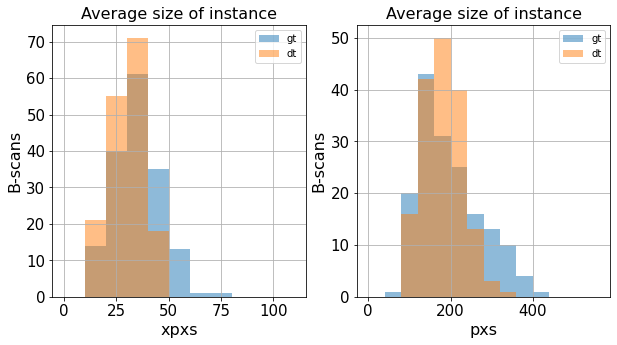

In [13]:
plt.figure(figsize=[10,5])
plt.subplot(121)
bins = np.arange(0,120,10)
ax = (dfsub.gt_xpxs/dfsub.gt_instances).hist(bins = bins,alpha=.5,label='gt')
ax = (dfsub.dt_xpxs/dfsub.dt_instances).hist(bins=bins,alpha=.5,label='dt')
ax.set_xlabel('xpxs')
ax.set_ylabel('B-scans')
ax.set_title('Average size of instance')
ax.legend()

plt.subplot(122)
bins = np.arange(0,600,40)
ax = (dfsub.gt_pxs/dfsub.gt_instances).hist(bins=bins,alpha=.5,label='gt')
ax = (dfsub.dt_pxs/dfsub.dt_instances).hist(bins=bins,alpha=.5,label='dt')
ax.set_xlabel('pxs')
ax.set_ylabel('B-scans')
ax.set_title('Average size of instance')
ax.legend()

In [14]:
import pandas as pd
newdf = pd.DataFrame([idx.strip('.png').split('_') for idx in df.index],columns=['ptid','eye','scan'],index = df.index)
df = df.merge(newdf,how='inner',left_index=True,right_index=True)

In [15]:
ImgIds = np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:10].values

In [16]:
from plain_train_net import OutputVis
vis = OutputVis(dataset_name,cfg,0.5)
#vis.output_to_pdf(ImgIds,os.path.join(cfg.OUTPUT_DIR,'top10_xpxs_err.pdf'),dfimg =myeval.dfimg )

In [17]:
dfpts = df.groupby(['ptid','eye'])['gt_instances','gt_pxs','gt_xpxs','dt_instances','dt_pxs','dt_xpxs'].sum()
pd.set_option('display.max_rows',500)
dfpts

/root/miniconda3/envs/detectron/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


gt_instances   gt_pxs  gt_xpxs  dt_instances   dt_pxs  dt_xpxs
ptid   eye                                                                
101008 OD            0.0      0.0      0.0          11.0   2080.0    335.0
       OS            0.0      0.0      0.0          14.0   2227.0    386.0
101078 OD           58.0   7280.0    964.0          33.0   4372.0    561.0
101087 OS          100.0  22984.0   3939.0          83.0  17004.0   2615.0
101142 OD           39.0   9214.0   1475.0          38.0   6721.0   1244.0
       OS           51.0  13598.0   2219.0          65.0  13034.0   2232.0
101257 OD          196.0  30381.0   7207.0         107.0  18863.0   3975.0
       OS          146.0  27493.0   6000.0          94.0  17041.0   3379.0
101285 OS           66.0  18079.0   2485.0          96.0  20017.0   2892.0
103030 OD           39.0   5473.0   1084.0          11.0   1947.0    307.0
       OS           60.0   9963.0   1868.0          30.0   4635.0    773.0
104002 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104012 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104018 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104019 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           2.0    339.0     37.0
104022 OD            0.0      0.0      0.0           1.0    173.0     20.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104027 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104028 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104030 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104037 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104043 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104048 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104055 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0